In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

class ProyectoRegresionLinealCSV:
    def __init__(self, ruta_csv, nombre_col_y):
        """
        Carga el dataset desde un archivo CSV, omite las variables no numéricas (object/category),
        y conserva solo int y float para la regresión.

        Parámetros:
        ruta_csv (str): Ruta al archivo CSV con los datos.
        nombre_col_y (str): Nombre de la columna que se usará como variable dependiente (Y).
        """
        # 1) Cargar el dataset original
        self.df = pd.read_csv(ruta_csv)

        # Mezclamos aleatoriamente las filas
        self.df = self.df.sample(frac=1, random_state=42).reset_index(drop=True)

        # Verificar que la columna Y exista
        if nombre_col_y not in self.df.columns:
            raise ValueError(f"La columna '{nombre_col_y}' no se encuentra en el CSV.")

        self.col_y = nombre_col_y

        # 2) Dividir en entrenamiento (80%) y validación (20%)
        n_filas = len(self.df)
        self.n_train = int(0.8 * n_filas)
        self.df_entrenamiento = self.df.iloc[:self.n_train, :].copy()
        self.df_validacion    = self.df.iloc[self.n_train:, :].copy()

        # Aquí almacenaremos las 2 mejores columnas numéricas (int/float) para la regresión univariable
        self.mejores_vars = []

    def analisis_exploratorio(self):
        """
        Analiza el DataFrame de entrenamiento (self.df_entrenamiento).

        1) Distribución individual:
           - Si int => barplot
           - Si float => histplot
           - Si object/category => se omite
        2) Comparación con la variable objetivo (Y):
           - Si int => boxplot vs Y
           - Si float => scatterplot vs Y
           - Si object/category => se omite
        """
        print("=== Análisis Exploratorio (Entrenamiento) ===")
        df_train = self.df_entrenamiento

        # --- DISTRIBUCIÓN INDIVIDUAL ---
        for col in df_train.columns:
            plt.figure()

            # No queremos analizar Y en un barplot/hist a menos que lo desees. Aquí lo dejamos:
            if col == self.col_y:
                # Por si quieres ver la distribución de la Y también (histplot, pues suele ser float)
                if pd.api.types.is_float_dtype(df_train[col]):
                    sns.histplot(data=df_train, x=col, kde=True)
                    plt.title(f"Histograma de '{col}' (Y, float)")
                elif pd.api.types.is_integer_dtype(df_train[col]):
                    value_counts = df_train[col].value_counts(dropna=False)
                    sns.barplot(x=value_counts.index.astype(str), y=value_counts.values)
                    plt.title(f"Barplot de '{col}' (Y, int)")
                else:
                    plt.close()
                    continue
                plt.show()
                continue

            # Columna distinta de Y
            if pd.api.types.is_integer_dtype(df_train[col]):
                # int => barplot
                value_counts = df_train[col].value_counts(dropna=False)
                sns.barplot(x=value_counts.index.astype(str), y=value_counts.values)
                plt.title(f"Barplot de '{col}' (int, discreta numérica)")
                plt.xlabel(col)
                plt.ylabel("Frecuencia")
                plt.xticks(rotation=45)

            elif pd.api.types.is_float_dtype(df_train[col]):
                # float => histplot
                sns.histplot(data=df_train, x=col, kde=True)
                plt.title(f"Histograma de '{col}' (float, continua)")

            else:
                # si es object/category => se omite
                plt.close()
                continue

            plt.tight_layout()
            plt.show()

        # --- COMPARACIÓN vs. Y ---
        for col in df_train.columns:
            if col == self.col_y:
                continue

            if pd.api.types.is_integer_dtype(df_train[col]):
                # int => boxplot (x=col, y=Y)
                plt.figure()
                sns.boxplot(x=col, y=self.col_y, data=df_train)
                plt.title(f"Boxplot: Y={self.col_y} vs X={col} (X int discreta numérica)")
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()

            elif pd.api.types.is_float_dtype(df_train[col]):
                # float => scatterplot
                plt.figure()
                plt.scatter(df_train[col], df_train[self.col_y])
                plt.title(f"Scatterplot: Y={self.col_y} vs X={col} (X float continua)")
                plt.xlabel(col)
                plt.ylabel(self.col_y)
                plt.tight_layout()
                plt.show()

            else:
                # object/category => se omite
                continue

    def encontrar_mejores_variables(self):
        """
        Selecciona las 2 columnas numéricas (int o float) con mayor correlación absoluta
        respecto a la variable objetivo (Y) en el set de entrenamiento.
        """
        df_train = self.df_entrenamiento

        # Extraemos la columna Y (asumiendo que es numérica, p.ej. float)
        y = df_train[self.col_y].values

        correlaciones = {}

        # Recorremos columnas excepto Y
        for col in df_train.columns:
            if col == self.col_y:
                continue

            # Solo consideramos variables int o float
            if (pd.api.types.is_integer_dtype(df_train[col]) or
                pd.api.types.is_float_dtype(df_train[col])):

                x = df_train[col].values
                # Calcular correlación
                corr = np.corrcoef(x, y)[0, 1]
                correlaciones[col] = corr

        # Ordenar por correlación absoluta
        correlaciones_ordenadas = sorted(correlaciones.items(), key=lambda x: abs(x[1]), reverse=True)

        if len(correlaciones_ordenadas) < 2:
            raise ValueError("No hay suficientes variables numéricas (int/float) para elegir las 2 mejores.")

        # Tomar las 2 de mayor correlación absoluta
        self.mejores_vars = [correlaciones_ordenadas[0][0], correlaciones_ordenadas[1][0]]

        print("\nLas dos variables numéricas (int/float) más correlacionadas con", self.col_y, "son:")
        for var, corr in correlaciones_ordenadas[:2]:
            print(f"  {var}: corr={corr:.4f}")

    def entrenar_modelo_gradiente_desc(self, x, y, epochs=100, alpha=0.001, imprimir_error_cada=10):
        """
        Entrena un modelo de regresión lineal univariable y = b0 + b1*x
        con gradiente descendente.

        Devuelve:
         - historial_modelos (dict): iter -> [b1, b0]
         - errores (list): lista con el error (MSE/2) de cada iteración
        """
        n = len(x)
        # Matriz X_aug -> [x, 1]
        X_aug = np.column_stack((x, np.ones(n)))

        # Inicialización
        b1, b0 = 0.0, 0.0
        theta = np.array([b1, b0])  # [b1, b0]

        historial_modelos = {}
        errores = []

        for epoch in range(1, epochs+1):
            y_hat = X_aug @ theta  # b1*x + b0
            error = (1/(2*n)) * np.sum((y_hat - y)**2)
            errores.append(error)

            grad = (1/n) * (X_aug.T @ (y_hat - y))  # dE/dtheta
            theta = theta - alpha * grad

            historial_modelos[epoch] = np.copy(theta)

            if epoch % imprimir_error_cada == 0:
                print(f"Iteración {epoch} - Error: {error:.6f}")

        return historial_modelos, errores

    def graficar_error(self, errores):
        """
        Grafica el error (MSE/2) vs iteración
        """
        plt.figure()
        plt.plot(range(1, len(errores)+1), errores)
        plt.xlabel("Iteración")
        plt.ylabel("Error (MSE/2)")
        plt.title("Curva de aprendizaje (Gradiente descendente)")
        plt.show()

    def graficar_evolucion_modelo(self, x, y, historial_modelos, n_saltos=10):
        """
        Muestra cómo evoluciona la recta del modelo a lo largo de las iteraciones.
        """
        plt.figure()
        plt.scatter(x, y, label="Datos de entrenamiento")

        max_iter = max(historial_modelos.keys())
        iteraciones_interes = range(n_saltos, max_iter+1, n_saltos)

        for i in iteraciones_interes:
            b1, b0 = historial_modelos[i]
            y_pred = b1*x + b0
            plt.plot(x, y_pred, label=f"Iter {i}")

        # Última recta
        b1_final, b0_final = historial_modelos[max_iter]
        y_pred_final = b1_final*x + b0_final
        plt.plot(x, y_pred_final, label=f"Final (Iter {max_iter})", linewidth=2)

        plt.title("Evolución de la recta (Gradiente Desc.)")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()

    def entrenar_modelo_sklearn(self, x, y):
        """
        Entrena un modelo de regresión lineal univariable con scikit-learn
        y retorna el modelo entrenado.
        """
        X_2d = x.reshape(-1, 1)
        modelo = LinearRegression()
        modelo.fit(X_2d, y)
        return modelo

    def predecir_combinado(self, x_nuevo, theta_manual, modelo_sklearn):
        """
        Devuelve 3 predicciones:
         1) manual,
         2) sklearn,
         3) promedio de ambas.
        """
        b1, b0 = theta_manual
        y_hat_manual = b1*x_nuevo + b0

        X_2d = x_nuevo.reshape(-1,1)
        y_hat_sklearn = modelo_sklearn.predict(X_2d)

        y_hat_promedio = (y_hat_manual + y_hat_sklearn) / 2
        return y_hat_manual, y_hat_sklearn, y_hat_promedio

    def error_mse(self, y_true, y_pred):
        """
        Calcula MSE.
        """
        return np.mean((y_true - y_pred)**2)

    def ejecutar_proyecto(self, epochs=200, alpha=0.001, imprimir_error_cada=20):
        """
        1) Análisis exploratorio
        2) Selección de 2 mejores columnas numéricas (int/float) por correlación con Y
        3) Entrenamiento univariable (manual y sklearn) para cada una
        4) Validación y comparación de errores
        """
        print("========== (1) Análisis Exploratorio ==========")
        self.analisis_exploratorio()

        print("========== (2) Seleccionar Mejores Variables (int/float) ==========")
        self.encontrar_mejores_variables()

        df_train = self.df_entrenamiento
        df_val   = self.df_validacion

        y_train = df_train[self.col_y].values
        y_val   = df_val[self.col_y].values

        errores_finales = {
            "var": [],
            "error_manual": [],
            "error_sklearn": [],
            "error_promedio": []
        }

        # 3) Entrenar
        for var in self.mejores_vars:
            print(f"\n=== Entrenando con variable: {var} ===")
            x_train = df_train[var].values
            x_val   = df_val[var].values

            # A) Gradiente Descendente (Manual)
            historial_modelos, lista_errores = self.entrenar_modelo_gradiente_desc(
                x_train, y_train, epochs=epochs, alpha=alpha,
                imprimir_error_cada=imprimir_error_cada
            )

            self.graficar_error(lista_errores)
            self.graficar_evolucion_modelo(x_train, y_train, historial_modelos, n_saltos=epochs//5)

            b1_final, b0_final = historial_modelos[epochs]
            print(f"Modelo manual final: y = {b1_final:.4f} * x + {b0_final:.4f}")

            # B) scikit-learn
            modelo_sklearn = self.entrenar_modelo_sklearn(x_train, y_train)
            print(f"Modelo sklearn: y = {modelo_sklearn.coef_[0]:.4f} * x + {modelo_sklearn.intercept_:.4f}")

            # C) Validación
            y_hat_manual, y_hat_sklearn, y_hat_promedio = self.predecir_combinado(
                x_val,
                theta_manual=np.array([b1_final, b0_final]),
                modelo_sklearn=modelo_sklearn
            )

            error_manual   = self.error_mse(y_val, y_hat_manual)
            error_sklearn  = self.error_mse(y_val, y_hat_sklearn)
            error_promedio = self.error_mse(y_val, y_hat_promedio)

            print(f"Error MSE validación - Manual:   {error_manual:.6f}")
            print(f"Error MSE validación - sklearn:  {error_sklearn:.6f}")
            print(f"Error MSE validación - Promedio: {error_promedio:.6f}")

            errores_finales["var"].append(var)
            errores_finales["error_manual"].append(error_manual)
            errores_finales["error_sklearn"].append(error_sklearn)
            errores_finales["error_promedio"].append(error_promedio)

        # 4) Gráfico comparativo de errores
        df_errores = pd.DataFrame(errores_finales)

        plt.figure()
        x_pos = np.arange(len(df_errores))
        bar_width = 0.2

        plt.bar(x_pos - bar_width,
                df_errores["error_manual"],
                width=bar_width,
                label="Manual")

        plt.bar(x_pos,
                df_errores["error_sklearn"],
                width=bar_width,
                label="sklearn")

        plt.bar(x_pos + bar_width,
                df_errores["error_promedio"],
                width=bar_width,
                label="Promedio")

        plt.xticks(x_pos, df_errores["var"])
        plt.ylabel("MSE (validación)")
        plt.title("Comparación de Errores (Univariable, int/float)")
        plt.legend()
        plt.show()

        # Conclusión final
        print("\n======== CONCLUSIÓN FINAL ========")
        for idx, row in df_errores.iterrows():
            var_ = row["var"]
            min_error = min(row["error_manual"], row["error_sklearn"], row["error_promedio"])
            if min_error == row["error_manual"]:
                mejor_modelo = "Manual"
            elif min_error == row["error_sklearn"]:
                mejor_modelo = "sklearn"
            else:
                mejor_modelo = "Promedio"

            print(f"Para la variable '{var_}' el mejor modelo es '{mejor_modelo}', con MSE = {min_error:.6f}")




========== (1) Análisis Exploratorio ==========
=== Análisis Exploratorio (Entrenamiento) ===


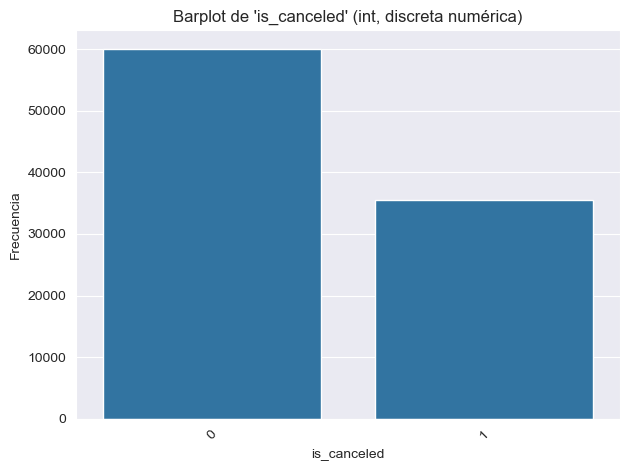

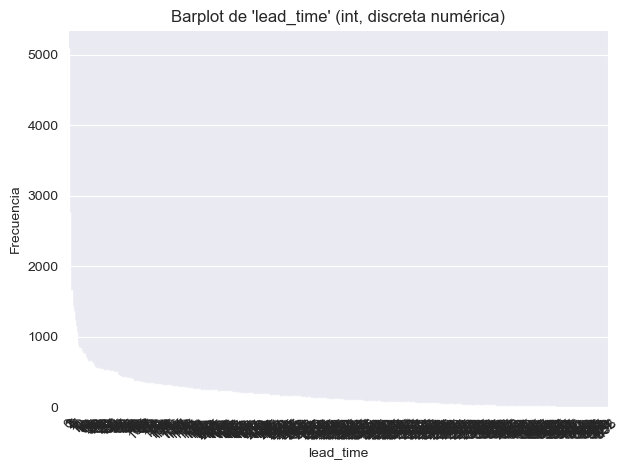

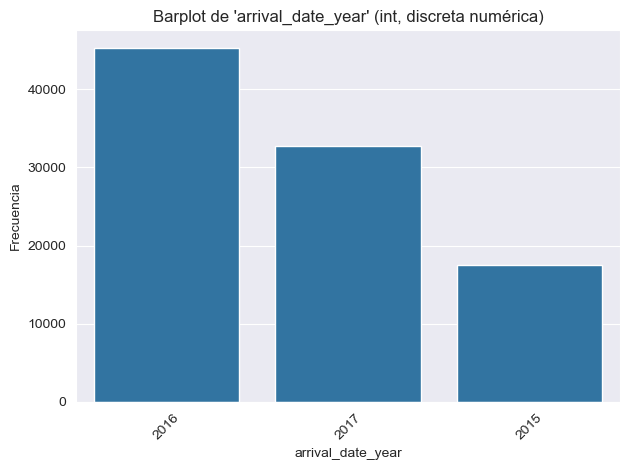

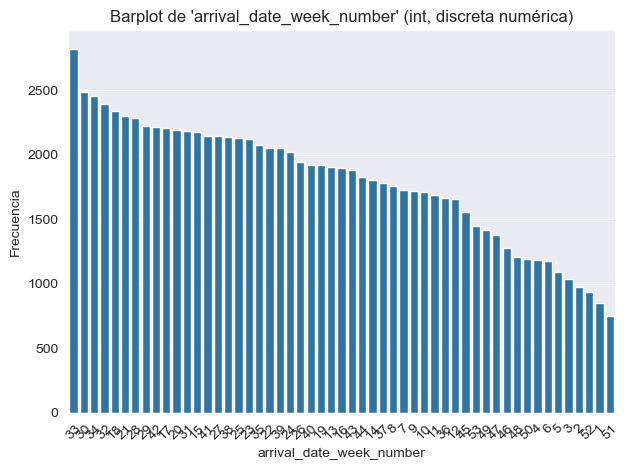

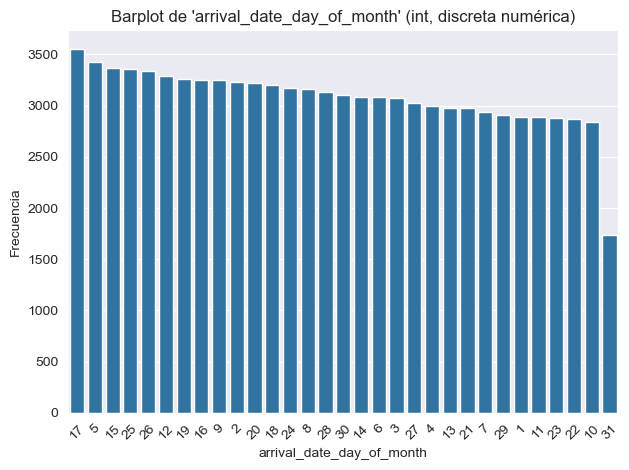

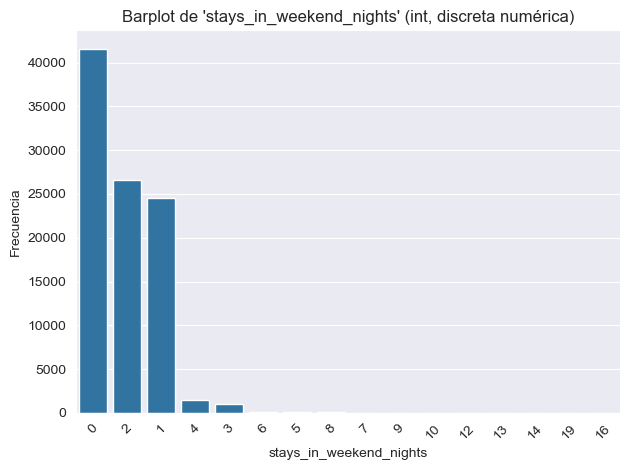

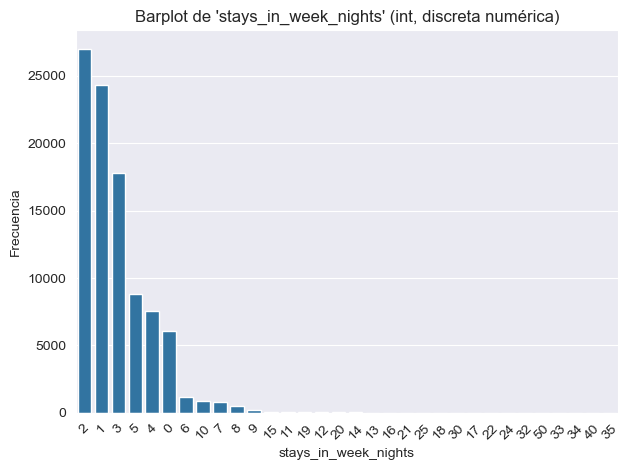

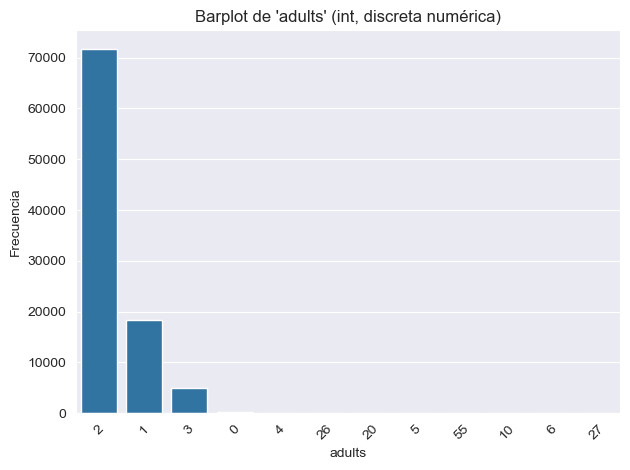

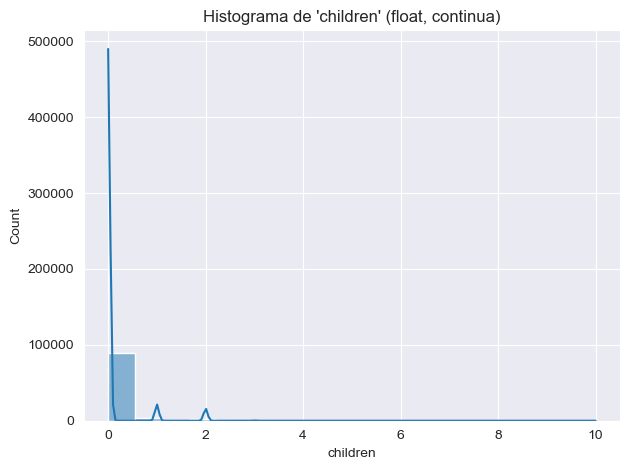

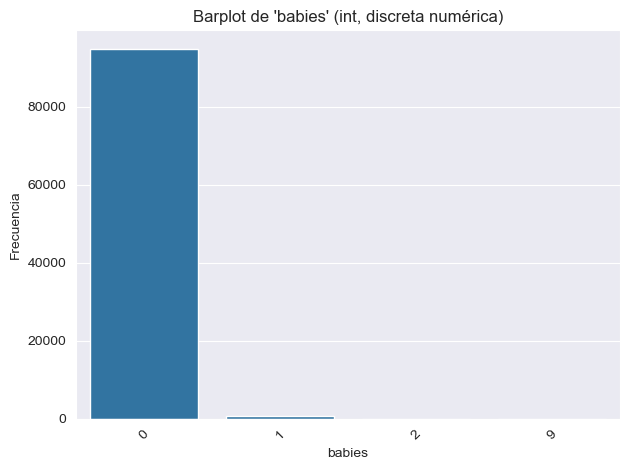

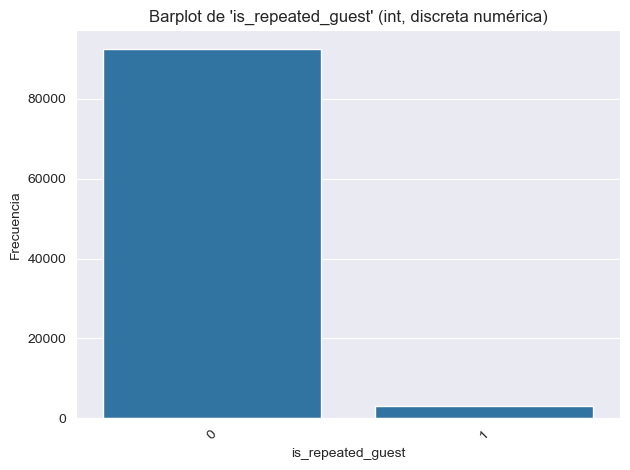

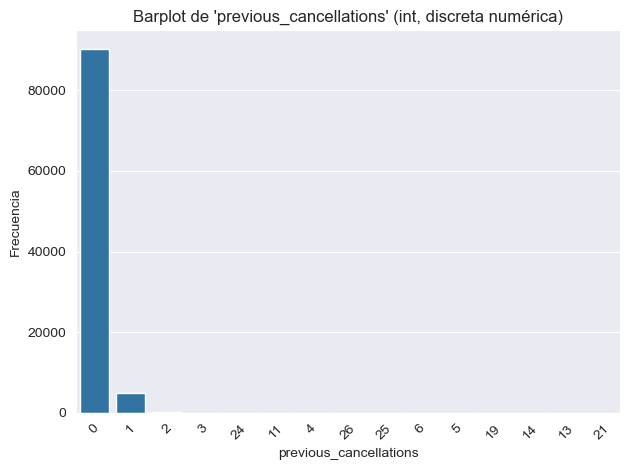

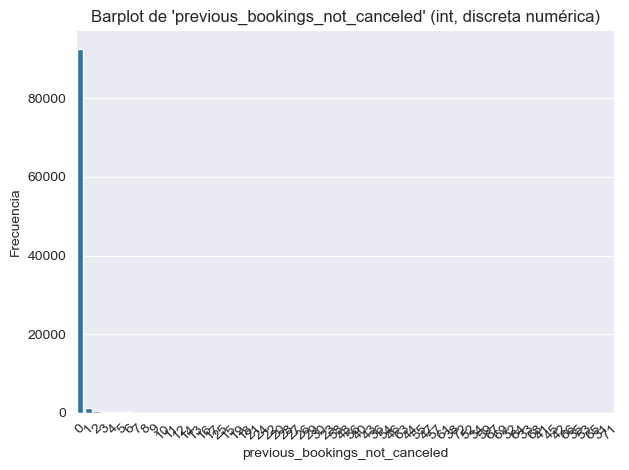

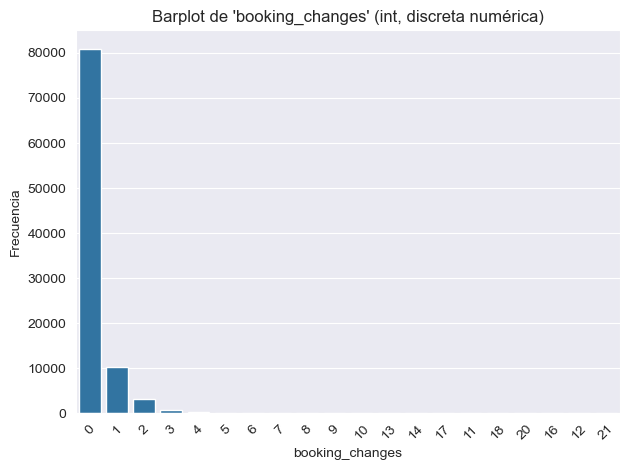

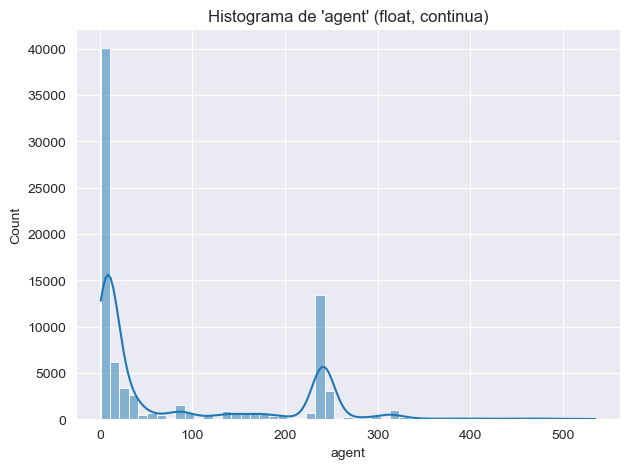

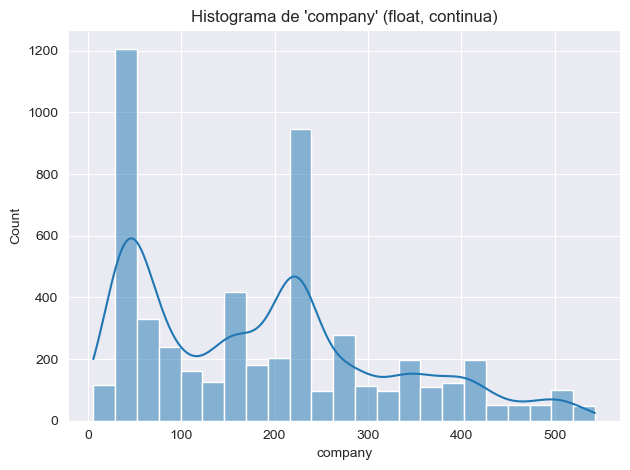

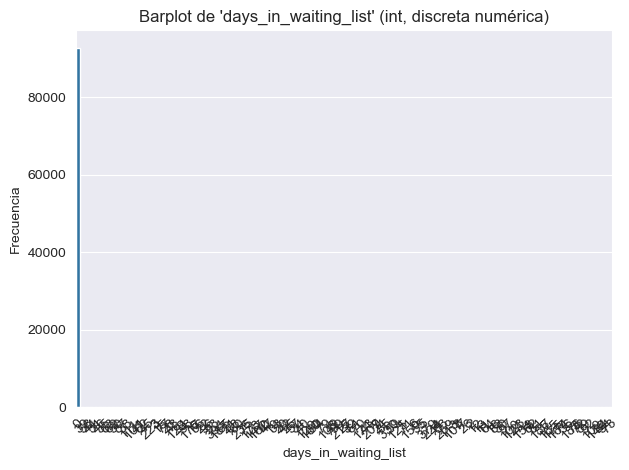

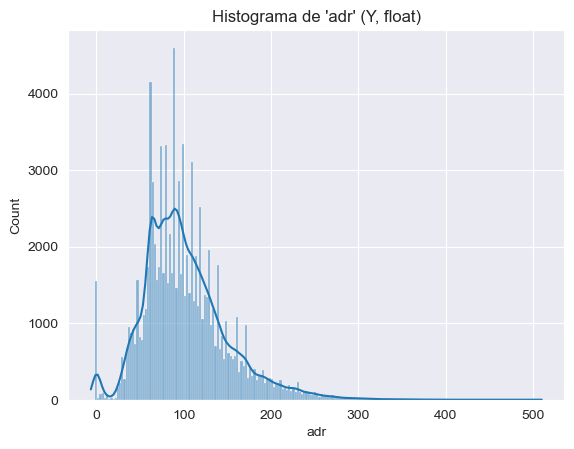

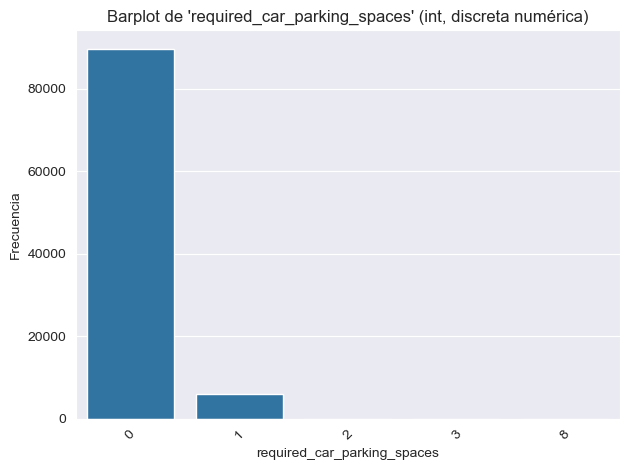

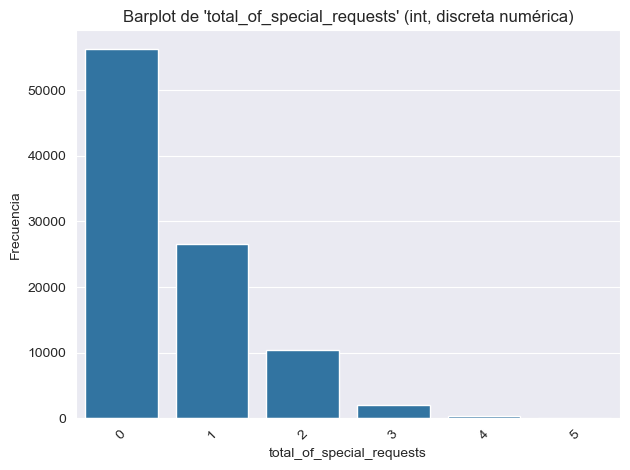

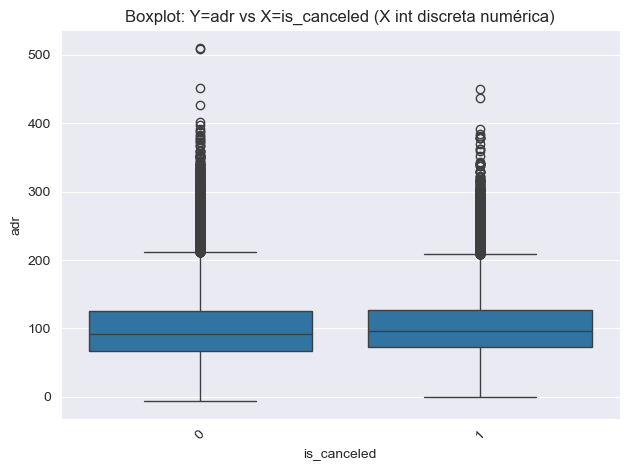

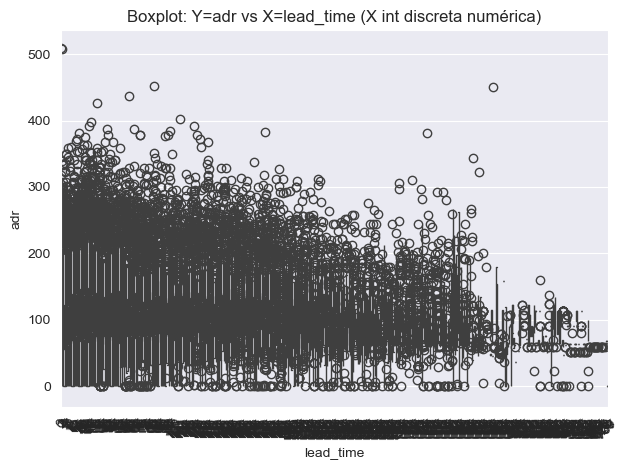

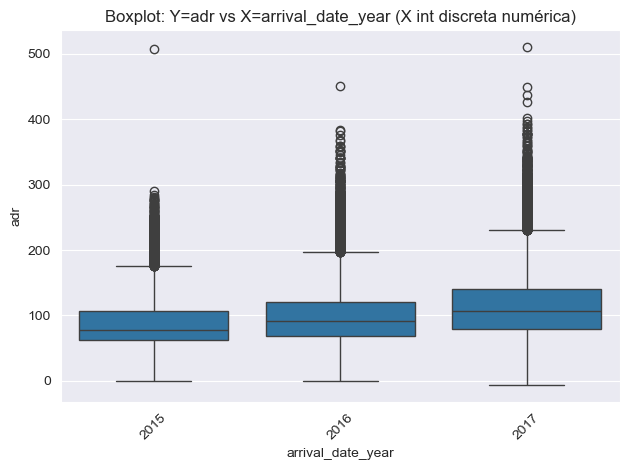

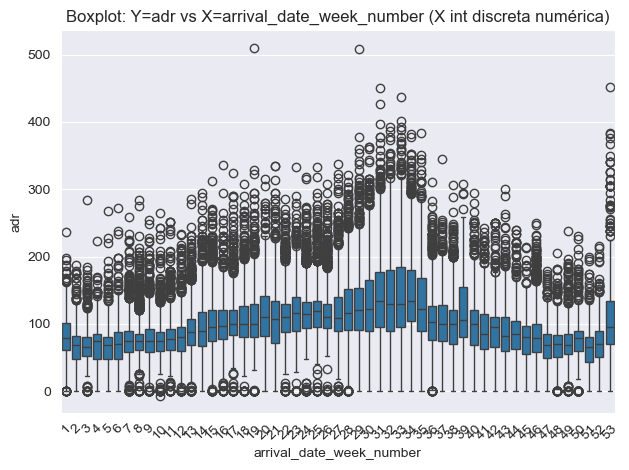

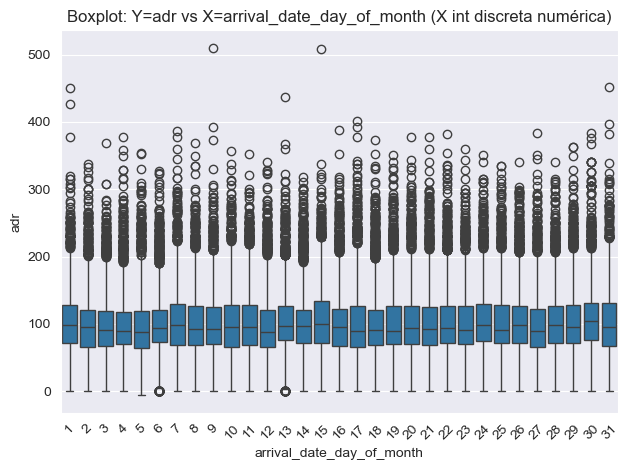

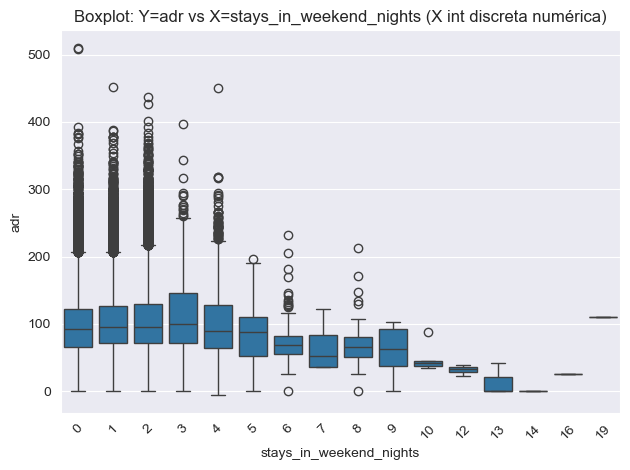

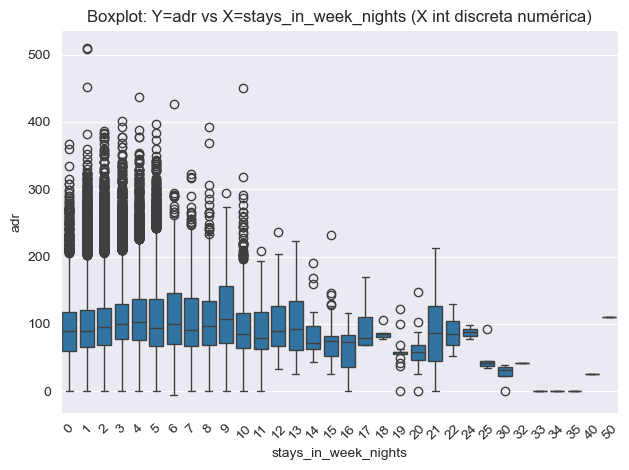

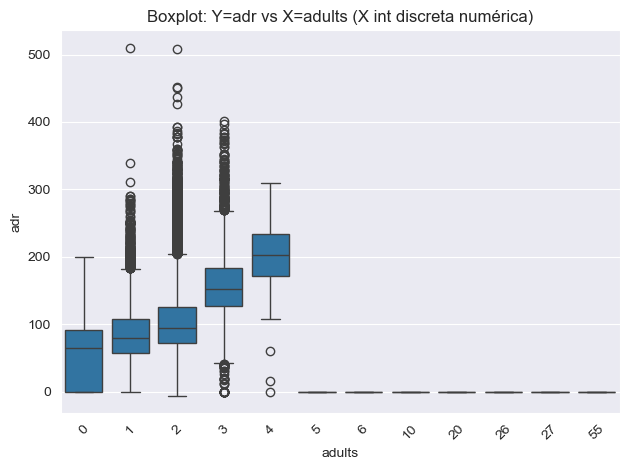

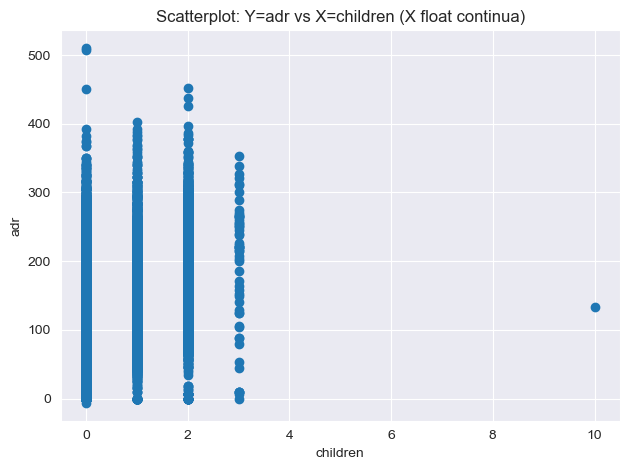

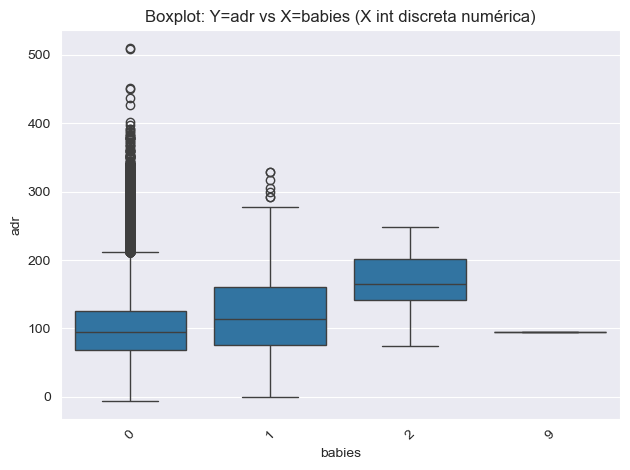

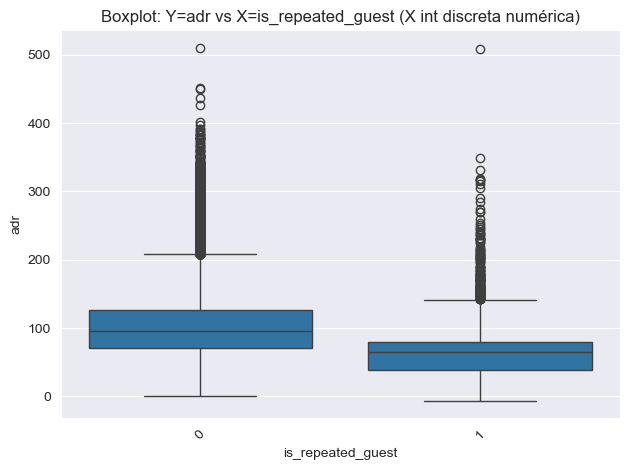

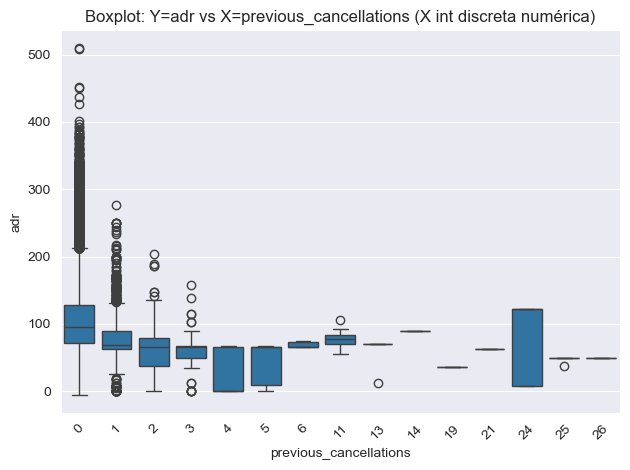

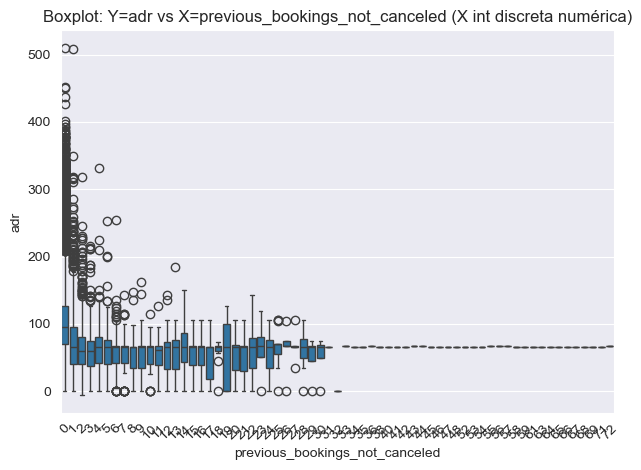

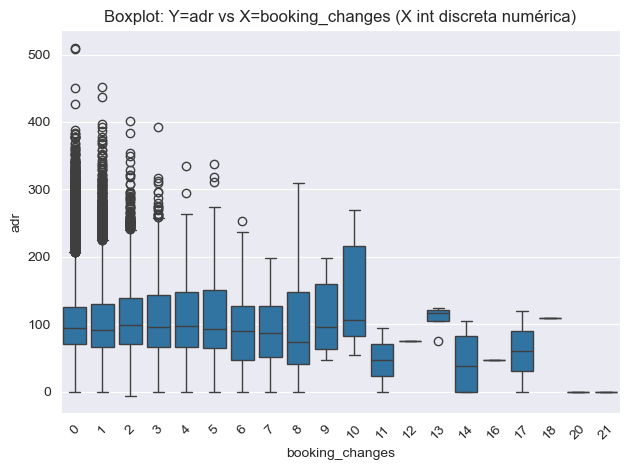

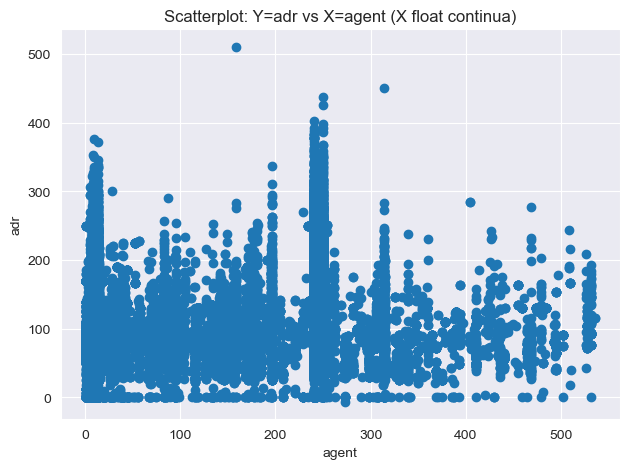

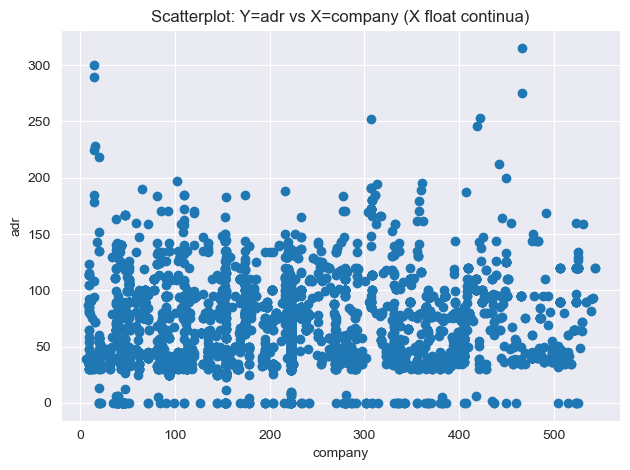

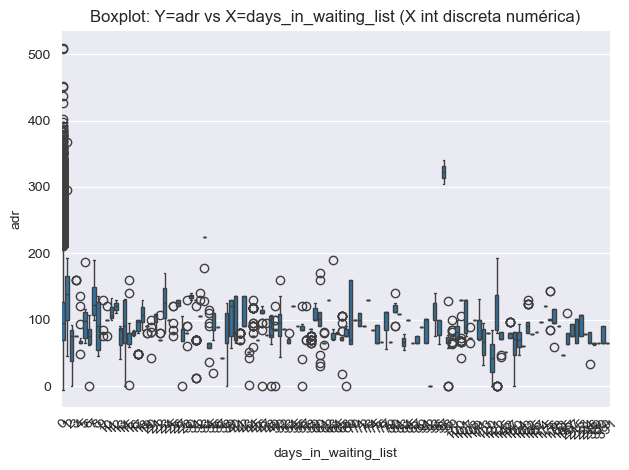

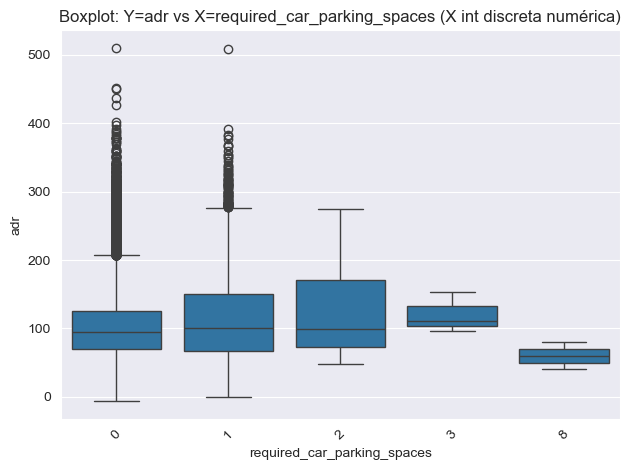

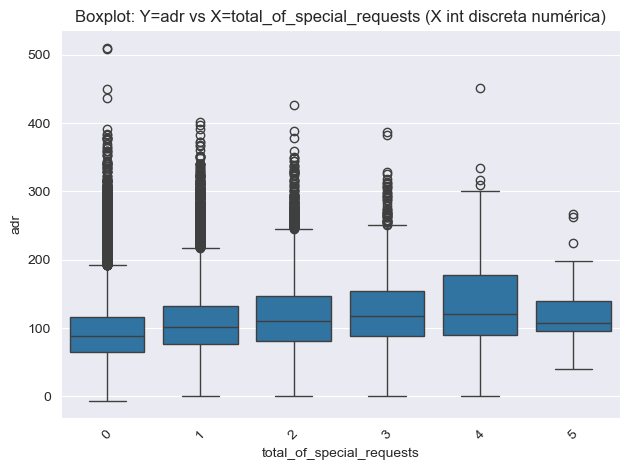

========== (2) Seleccionar Mejores Variables (int/float) ==========

Las dos variables numéricas (int/float) más correlacionadas con adr son:
  adults: corr=0.2593
  arrival_date_year: corr=0.2104

=== Entrenando con variable: adults ===
Iteración 20 - Error: 5482.858365
Iteración 40 - Error: 4738.838074
Iteración 60 - Error: 4122.060419
Iteración 80 - Error: 3610.759973
Iteración 100 - Error: 3186.894397
Iteración 120 - Error: 2835.507584
Iteración 140 - Error: 2544.201743
Iteración 160 - Error: 2302.699788
Iteración 180 - Error: 2102.482581
Iteración 200 - Error: 1936.488223


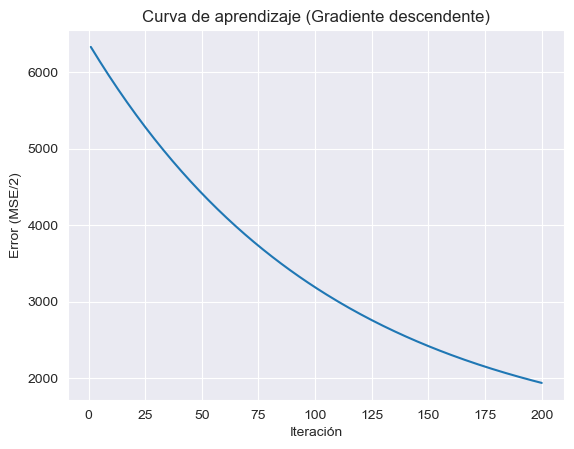

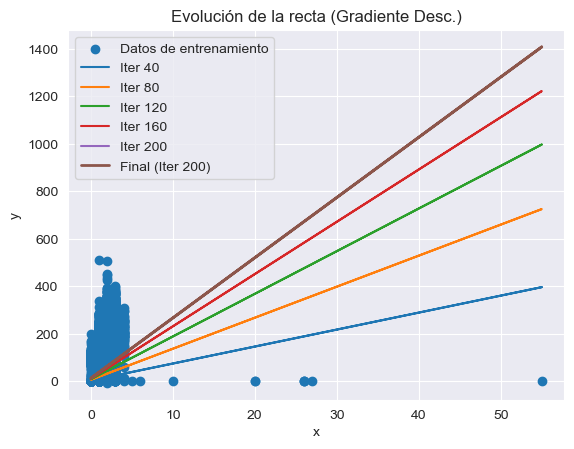

Modelo manual final: y = 25.3637 * x + 13.4078
Modelo sklearn: y = 22.6870 * x + 59.6844
Error MSE validación - Manual:   5248.408668
Error MSE validación - sklearn:  3503.948313
Error MSE validación - Promedio: 3948.979126

=== Entrenando con variable: arrival_date_year ===
Iteración 20 - Error: 714693802327153431982751138065312859560961551498852260224751032811938441688698305001288266075700508865297106124680190763185446315532759334912.000000
Iteración 40 - Error: 1628631382934982302910740404192898608312600861790357794499283370291351078038819301139252204770713167213644566936076866021528180726414745775104014310081801671333440013626366889693051155993373871277141645667550011939237343144158245062675993368634133907355710159519103175918690631302512640.000000
Iteración 60 - Error: inf
Iteración 80 - Error: inf
Iteración 100 - Error: nan
Iteración 120 - Error: nan
Iteración 140 - Error: nan
Iteración 160 - Error: nan
Iteración 180 - Error: nan
Iteración 200 - Error: nan


C:\Users\fjgon\miniconda3\envs\Ciencia_Datos\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\fjgon\AppData\Local\Temp\ipykernel_40748\3321980450.py:186: RuntimeWarning: overflow encountered in square
  error = (1/(2*n)) * np.sum((y_hat - y)**2)
C:\Users\fjgon\AppData\Local\Temp\ipykernel_40748\3321980450.py:189: RuntimeWarning: overflow encountered in matmul
  grad = (1/n) * (X_aug.T @ (y_hat - y))  # dE/dtheta
C:\Users\fjgon\AppData\Local\Temp\ipykernel_40748\3321980450.py:189: RuntimeWarning: invalid value encountered in matmul
  grad = (1/n) * (X_aug.T @ (y_hat - y))  # dE/dtheta
C:\Users\fjgon\AppData\Local\Temp\ipykernel_40748\3321980450.py:190: RuntimeWarning: invalid value encountered in subtract
  theta = theta - alpha * grad


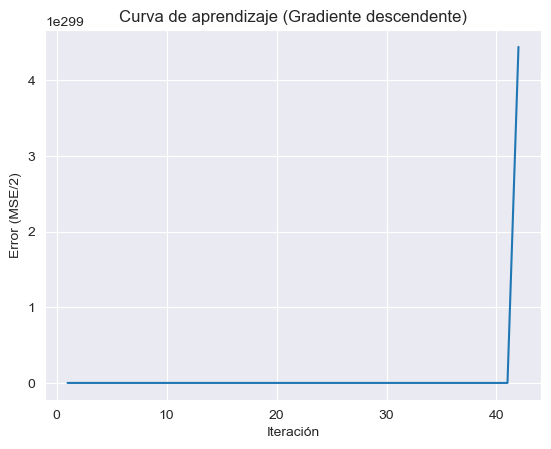

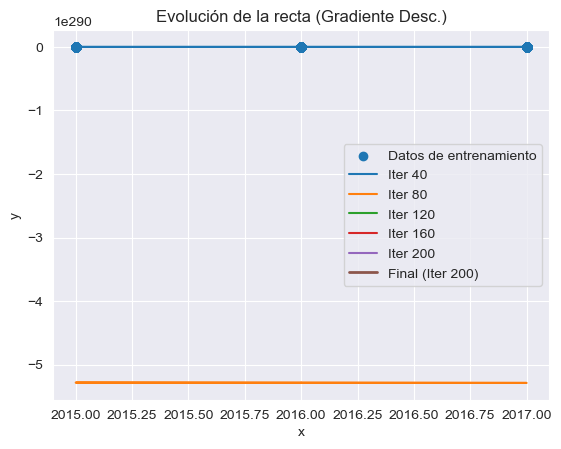

Modelo manual final: y = nan * x + nan
Modelo sklearn: y = 14.2679 * x + -28664.4827
Error MSE validación - Manual:   nan
Error MSE validación - sklearn:  3462.171729
Error MSE validación - Promedio: nan


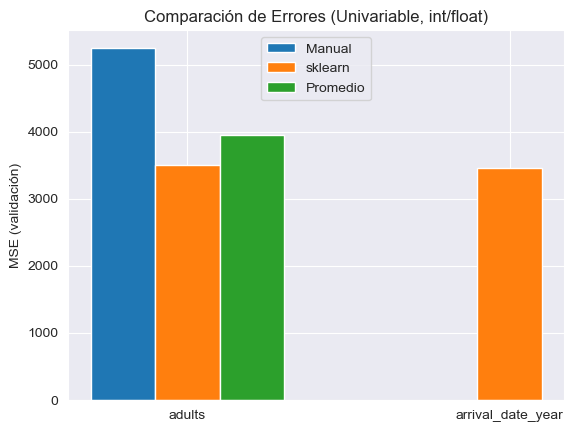


======== CONCLUSIÓN FINAL ========
Para la variable 'adults' el mejor modelo es 'sklearn', con MSE = 3503.948313
Para la variable 'arrival_date_year' el mejor modelo es 'Promedio', con MSE = nan


In [11]:
# =============================================================================
# EJEMPLO DE USO
# =============================================================================
if __name__ == "__main__":
    ruta_csv = "hotel_bookings.csv"
    columna_objetivo = "adr"  # Suponiendo que 'adr' es float

    proyecto = ProyectoRegresionLinealCSV(ruta_csv, columna_objetivo)
    proyecto.ejecutar_proyecto(
        epochs=200,
        alpha=0.001,
        imprimir_error_cada=20
    )
